In [2]:
import pandas as pd

In [ ]:
data = pd.read_csv('model_base_final.csv',index_col=0)
data.iloc[0]

# 划分数据集

In [21]:
select_lst = ['A正面','B负面','C中性','D讽刺','E无产品评价语意']
split_lst = {}
for i in select_lst:
    lst = data[data['answer2']==i].index.to_list()
    split_lst[i]=lst


In [45]:
import random
def random_sample(nums: list):

    return random.sample(nums, int(len(nums)*random.uniform(0.45,0.55)) )

In [46]:
lst_select_A = data.iloc[random_sample(split_lst['A正面'])]
lst_select_B = data.iloc[random_sample(split_lst['B负面'])]
lst_select_C = data.iloc[random_sample(split_lst['C中性'])]
lst_select_D = data.iloc[random_sample(split_lst['D讽刺'])]
lst_select_E = data.iloc[random_sample(split_lst['E无产品评价语意'])]

In [51]:
# 训练集
data_train = pd.concat([lst_select_A,lst_select_B,lst_select_C,lst_select_D,lst_select_E],axis=0)

In [58]:
# 验证集
temp = data.merge(data_train,how='outer',indicator=True)
data_val = temp[temp['_merge'] == 'left_only']

In [59]:
len(data_train),len(data_val) #(37123, 36869)

(37123, 36869)

In [62]:
data_train.to_csv('./dataset/train.csv',encoding='utf-8-sig')
data_val.to_csv('./dataset/val.csv',encoding='utf-8-sig')

## 结果情况验证

In [9]:
data_val = pd.read_csv('./out_csv/val.csv',index_col=0)
data_sft = pd.read_csv('./fine_turning_sft.csv', index_col=0)
data_dpo = pd.read_csv('./dpo.csv',index_col=0)

In [16]:
data_dpo

,fine_turing
0.0,"""分类标签"":""B负面情感语义"""
1.0,"""分类标签"":""B负面情感倾向性"""
2.0,"""分类标签"":""B消极评价语义"""
3.0,"""分类标签"":""B负面情感语义"""
4.0,"""分类标签"":""B消极情绪倾向"""
...,...
36864.0,"""分类标签"":""A积极评价语义倾向"""
36865.0,"""分类标签"":""A正面情感语义"""
36866.0,"""分类标签"":""A正面评价语境特征"""
36867.0,"""分类标签"":""B负面评价性质"""


In [3]:
for i in data_val.columns[10:15]:
    print(i,sum(data_val['answer2'] == data_val[i])/len(data_val))

qwen7_result_label_base 0.608641406059291
qwen7_result_label_simple 0.7139873606552931
qwen7_result_label_simple_4bit 0.7178388347934579
qwen7_result_label_simple_4bit_temp.5 0.7185982803981665
qwen7_result_label_simple_4bit_temp.3 0.7216089397596898


In [4]:
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score

In [7]:
## 混淆矩阵
## 将原始结果转为数值
select_lst = ['A正面','B负面','C中性','D讽刺','E无产品评价语意']

def convert_nums(x):
    for ind,i in enumerate(select_lst):
        if x == i:
            return ind
    return 5

In [6]:
sum(data_val[data_val['answer2'] == data_val['qwen7_result_label_base']]['answer2'] == 'C中性')

2815

In [7]:
cm1 = confusion_matrix(data_val['answer2'].map(convert_nums),data_val['qwen7_result_label_base'].map(convert_nums),normalize='pred')

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

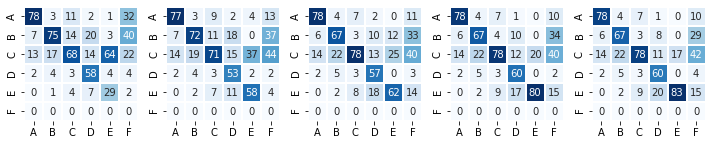

In [9]:
# plt.figure(figsize=(12,8),dpi=150)
# plt.figure(figsize=(12,6))
# 准确率
fig, axs = plt.subplots(1,5)
col_lst = data_val.columns[10:15]
fig.set_size_inches(10, 6)

for i in range(5):
    sns.heatmap(
        confusion_matrix(data_val['answer2'].map(convert_nums),data_val[col_lst[i]].map(convert_nums),normalize='pred')*100,
        ax=axs[i],
        square=True,
        cbar=None,
        linewidths=0.05,
        xticklabels=list('ABCDEF'),
        yticklabels=list('ABCDEF'),
        cmap='Blues',
        annot=True,
        fmt='.0f'

    )
plt.tight_layout()
plt.show()
    

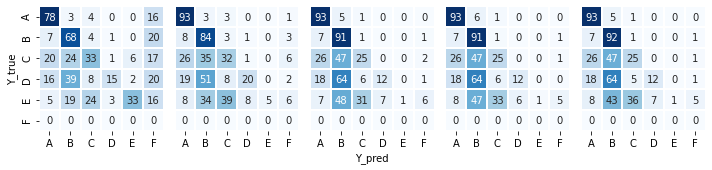

In [88]:
# plt.figure(figsize=(12,8),dpi=150)
# plt.figure(figsize=(12,6))
# 召回率
fig, axs = plt.subplots(1,5)
col_lst = data_val.columns[10:15]
fig.set_size_inches(10, 6)

for i in range(5):
    
    sns.heatmap(
        confusion_matrix(data_val['answer2'].map(convert_nums),data_val[col_lst[i]].map(convert_nums),normalize='true')*100,
        ax=axs[i],
        square=True,
        cbar=None,
        linewidths=0.05,
        xticklabels=list('ABCDEF'),
        yticklabels=list('ABCDEF'),
        cmap='Blues',
        annot=True,
        fmt='.0f'

    )
    if i > 0:
        axs[i].yaxis.set_visible(False)

axs[2].set_xlabel('Y_pred')
axs[0].set_ylabel('Y_true')

plt.tight_layout()
plt.savefig('./pic/recall.png')
plt.show()


In [7]:
def get_label(x):
    if x.replace('"分类标签":"','')[0] in "ABCDE":
        label = x.replace('"分类标签":"','')[0]
        
    else:
        label = "E"
    return label


In [86]:
for i in data_val.columns[10:15]:
    print(i,f1_score(data_val['answer2'].map(convert_nums),data_val[i].map(convert_nums),average='micro'))

qwen7_result_label_base 0.6503587372740801
qwen7_result_label_simple 0.6911549913403765
qwen7_result_label_simple_4bit 0.672127620068189
qwen7_result_label_simple_4bit_temp.5 0.6721306920478538
qwen7_result_label_simple_4bit_temp.3 0.6755205504616352


In [26]:
for i in data_val.columns[10:15]:
    print(i,precision_score(data_val['answer2'].map(convert_nums),data_val[i].map(convert_nums),average='micro'))

qwen7_result_label_base 0.608641406059291
qwen7_result_label_simple 0.7139873606552931
qwen7_result_label_simple_4bit 0.7178388347934579
qwen7_result_label_simple_4bit_temp.5 0.7185982803981665
qwen7_result_label_simple_4bit_temp.3 0.7216089397596898


In [27]:
for i in data_val.columns[10:15]:
    print(i,recall_score(data_val['answer2'].map(convert_nums),data_val[i].map(convert_nums),average='micro'))

qwen7_result_label_base 0.608641406059291
qwen7_result_label_simple 0.7139873606552931
qwen7_result_label_simple_4bit 0.7178388347934579
qwen7_result_label_simple_4bit_temp.5 0.7185982803981665
qwen7_result_label_simple_4bit_temp.3 0.7216089397596898
